# The main implementation of thesis project

# Setting customised library path

In [1]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configuration

In [3]:
image_size = (128, 128)
n_image_channels = 3

image_shape = (*image_size, n_image_channels) #input image shape

proj_dense_dims = (400, 200, ) #the projection head dense dims

batch_size = 128 # sample batch size

n_epochs = 20

temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training

# self-supervised contrastive learning
contrastive_imgaug_params = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}

# for classification
classification_imgaug_params = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

# Preparing the dataset

In [8]:
import tensorflow as tf
from tensorflow import keras

In [5]:
train_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                #subset = "training",
                #validation_split = 0.2,
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                #seed = 2771,
                shuffle = True
                )

Found 30800 files belonging to 154 classes.


In [6]:
test_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                #subset="validation",
                #validation_split = 0.2,
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                #seed = 2771,
                shuffle = True
                )

Found 7700 files belonging to 154 classes.


In [7]:
n_classes = len(train_dataset_.class_names)
n_samples = len(train_dataset_) * batch_size
n_batches = len(train_dataset_)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  30848
n_batches =  241


In [9]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([128, 128, 128, 3])

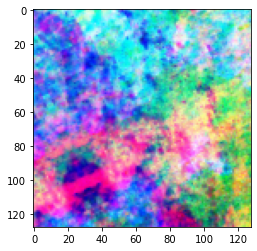

In [13]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

In [14]:
#import matplotlib.pyplot as plt
#import tensorflow as tf
#import tensorflow_datasets as tfds

#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [15]:
# Dataset hyperparameters
#unlabeled_dataset_size = 100000
#labeled_dataset_size = 5000
#image_size = 128
#image_channels = 3

# Algorithm hyperparameters
#num_epochs = 20
#batch_size = 525  # Corresponds to 200 steps per epoch
#width = 128
#temperature = 0.1
#n_classes = 154

# Stronger augmentations for contrastive, weaker ones for supervised training
#contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
#classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [16]:

# Distorts the color distibutions of images
class CustomisedColorAffineLayer(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images




In [80]:

# Image augmentation module
def build_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            #keras.layers.InputLayer(input_shape=(image_size, image_size, image_channels)),
            keras.layers.InputLayer(input_shape=image_shape),
            #preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            CustomisedColorAffineLayer(brightness, jitter),
        ]
    )


def visualize_augmentations(n_samples):
    # Sample a batch from a dataset
    #images = next(iter(train_dataset))[0][0][:num_images]
        
    images = next(iter(train_dataset))[0][:n_samples]
    
    #print(images.shape)
    #a=get_augmenter(**contrastive_augmentation)(images)
    
    #print(a.shape)
    
    
    # Apply augmentations
    augmented_images = zip(
        images,
        build_augmenter(**classification_imgaug_params)(images),
        build_augmenter(**contrastive_imgaug_params)(images),
        build_augmenter(**contrastive_imgaug_params)(images),
    )
    
    #print(augmented_images.shape)
    
    #return

    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    
    plt.figure(figsize=(n_samples * 2.2, 4 * 2.2), dpi = 100)
    
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, n_samples, row * n_samples + column + 1)
            plt.imshow(image, vmin=0, vmax=1)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


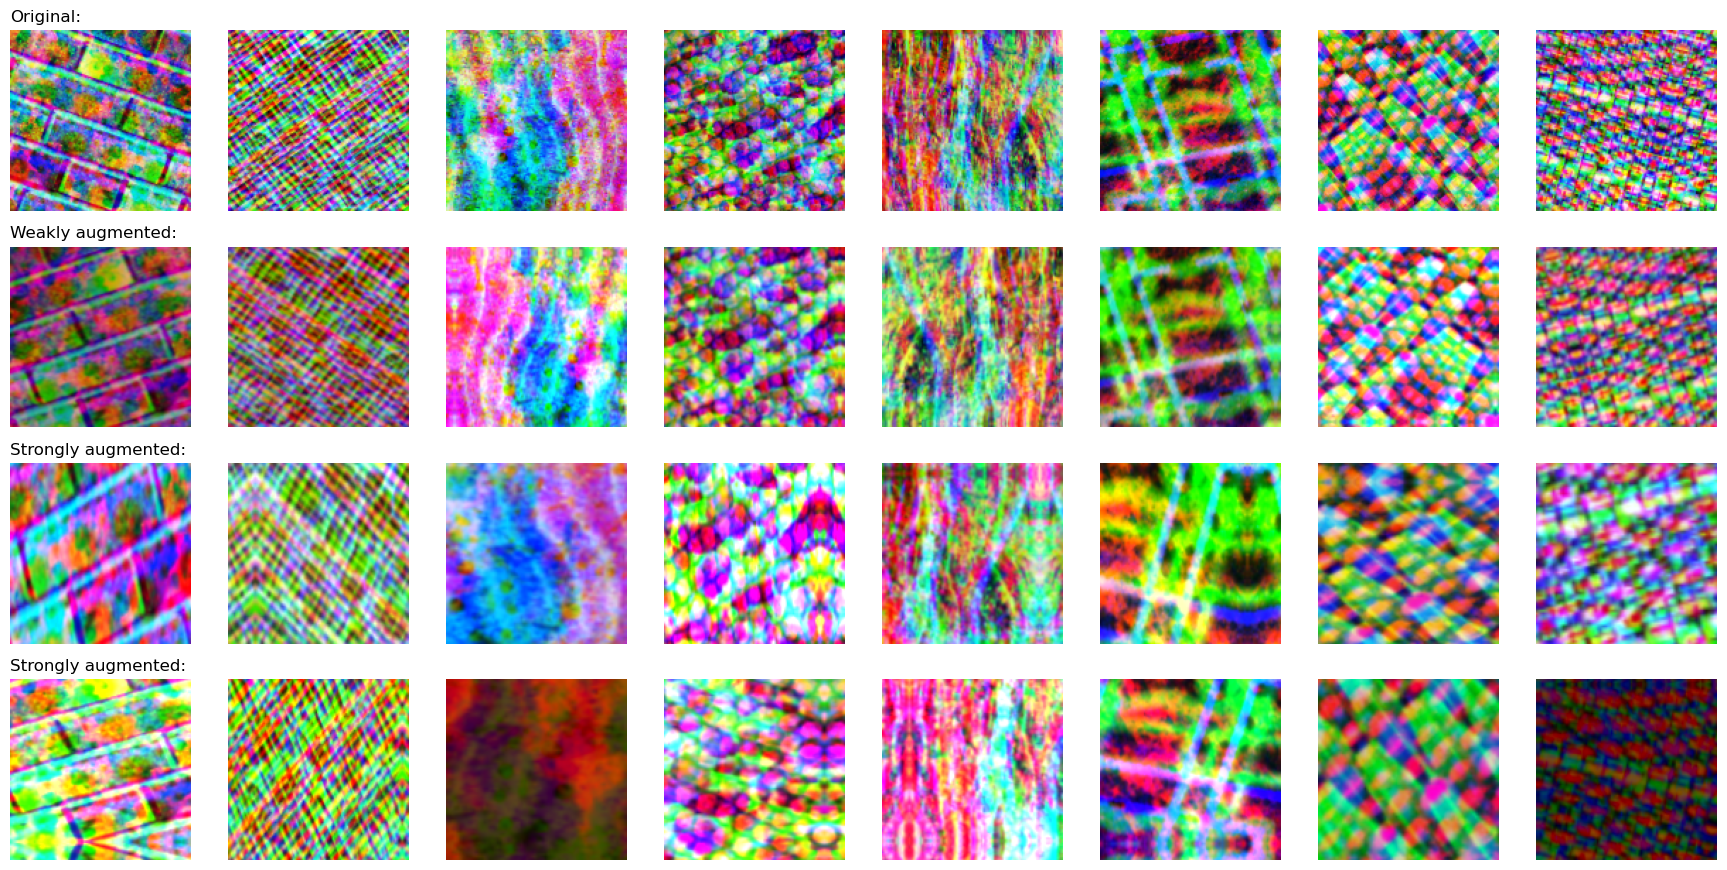

In [81]:
visualize_augmentations(n_samples = 8)

In [82]:
# Define the encoder architecture
def build_simple_encoder():
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape),
            
            layers.Conv2D(32, kernel_size=5, strides=2, activation="relu"),
            #layers.Dropout(0.2),
            
            layers.Conv2D(64, kernel_size=5, strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, kernel_size=5, strides=2, activation="relu"),
            #layers.Dropout(0.2),
            
            layers.Conv2D(256, kernel_size=5, strides=2, activation="relu"),
            
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Flatten(),
            #layers.BatchNormalization(),
            #layers.Dropout(0.6),
            
            layers.Dense(512, activation="relu"),
        ],
        name="encoder_simple",
    )

# Supervised learning with simple encoder

In [83]:
# Baseline supervised training with random initialization
baseline_model_simple = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape = image_shape),
        build_augmenter(**classification_imgaug_params),
        build_simple_encoder(),
        layers.Dense(n_classes),
    ],
    name="baseline_model_simple",
)

baseline_model_simple.compile(
        optimizer = keras.optimizers.Adam(),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

In [84]:
#baseline_model_simple.summary()

In [85]:
images = next(iter(train_dataset))[0]
out = baseline_model_simple.predict(images)
out.shape

(128, 154)

In [86]:
#labels = next(iter(train_dataset))[1]
#labels

In [87]:
#baseline_model_simple.layers[0].output

In [88]:
#baseline_model_simple.layers[-1].output

In [ ]:
baseline_simple_history = baseline_model_simple.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    #steps_per_epoch = 100,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 218s 901ms/step - loss: 3.6268 - acc: 0.1794 - val_loss: 27.4334 - val_acc: 0.0065
Epoch 2/20
 85/241 [=========>....................] - ETA: 2:07 - loss: 1.4279 - acc: 0.5631

In [ ]:
max_val_acc = max(baseline_simple_history.history["val_acc"]) * 100
max_train_acc = max(baseline_simple_history.history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

In [ ]:

val_accs = baseline_simple_history.history["val_acc"]
train_accs = baseline_simple_history.history["acc"]

plt.plot(val_accs, c = "blue")
plt.plot(train_accs, c = "pink")

plt.show()

# Contrastive learning with simple encoder

In [198]:

# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [keras.layers.InputLayer(input_shape=(width,)), layers.Dense(n_classes)], name="linear_probe"
        )

        #self.encoder.summary()
        #self.projection_head.summary()
        #self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        
        
        
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        #(unlabeled_images, _), (labeled_images, labels) = data

        
        #print("data[0].type=", type(data[0]))
        #print("data[1].type=", type(data[1]))
        
        
        # Both labeled and unlabeled images are used, without labels
        #images = tf.concat((unlabeled_images, labeled_images), axis=0)
        images,labels = data
        
        #images = tf.concat(images, axis=0)
        #images = tf.convert_to_tensor(images, dtype=tf.float32)
        
        #print("labels.type=",type(labels))
        #print("images.shape=", images.shape)
        #print(dir(labels))
        #print(type(images))
        
        #print("images=", images.get_shape())
        
        
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            #print("contrastive_loss=", contrastive_loss)
            
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        
        
        labeled_images = images
        
        # Labels are only used in evalutation for an on-the-fly logistic regression
        #preprocessed_images = self.classification_augmenter(labeled_images)
        preprocessed_images = self.classification_augmenter(labeled_images)
        
        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            #print("features.shape=", features.shape)
            class_logits = self.linear_probe(features)
            #print("class_logits.shape=", class_logits.shape)
            probe_loss = self.probe_loss(labels, class_logits)
            #print("probe_loss=", probe_loss)
            
            
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        #print("=====")
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


In [199]:
pretraining_model = ContrastiveModel()

# Contrastive pretraining
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

num_epochs=1
pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

 91/493 [====>.........................] - ETA: 8:02 - c_loss: 4.0606 - c_acc: 0.0907 - p_loss: 12.2671 - p_acc: 0.0070

KeyboardInterrupt: 